# Machine Learning for Nickel Catalyzed Borylation in EtOH

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math as math
import matplotlib.pyplot as plt

import xgboost as xgb
import shap

import pickle

### Load Preprocessed Ethanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_EtOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",80.44


In [3]:
dataset.Electrophile.unique().tolist()

['1H-indol-5-yl\xa0N,N-dimethylsulfamate',
 "2-bromo-1,1'-biphenyl",
 '2-Chloro-5-fluorotoluene',
 '2-Chloro-m-xylene',
 '(2-Methyl-1,3-benzothiazol-5-yl)\xa0N,N-dimethylsulfamate',
 '3-Bromothiophene',
 '3-Chloro-2-methylaniline',
 '4-Bromoanisole',
 '4-Bromobenzotrifluoride',
 '4-Chloro-N,N-dimethylbenzamide',
 '5-chloroindole',
 'BMS-929356',
 'Ethyl\xa04-chloro-3-fluorobenzoate',
 'methyl\xa04-bromobenzoate',
 'quinolin-6-yl dimethylsulfamate',
 '3-Bromoquinoline',
 '3-bromo-2-methylpyridine',
 'Clofibrate',
 '4-Bromo-2-fluoroanisole',
 '4-Bromo-2-fluorobenzonitrile',
 '(4-Phenylphenyl) N,N-dimethylsulfamate',
 '4-Bromo-1,2-(methylenedioxy)benzene',
 '5-Bromobenzofuran',
 '4-chloro-1-fluoro-2-methoxybenzene',
 '4-chlorobenzotrifluoride',
 '3-chloroquinoline',
 '5-bromo-2,4-dimethoxypyrimidine',
 'methyl\xa04-chlorobenzoate',
 '5-Chloro-1,3-benzodioxole',
 '4-chloro-2-fluoro-1-methoxybenzene',
 '4-Chloro-2-fluoroanisole',
 '4-Chlorobiphenyl',
 '4-Bromobiphenyl',
 '4-Chloro-2-fluorob

In [4]:
#load external ligand dataset in EtOH
ex_dataset = pd.read_csv("./data/external_ligand_data_EtOH.csv")
ex_dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,117.552360,56.790530,430.68256,1.797235,-0.062511,Cy-JohnPhos-OMe,InChI=1S/C25H33OP/c1-26-24-18-10-8-16-22(24)23...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",80.58
1,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,124.748184,58.538240,497.10650,1.784157,-0.063670,CPhos,InChI=1S/C28H41N2P/c1-29(2)25-19-13-20-26(30(3...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",67.06
2,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,109.966415,55.457000,415.06253,1.801754,-0.061979,CX-POMeCy,InChI=1S/C23H32NOP/c1-25-22-16-9-8-15-21(22)24...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",78.86
3,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,49.582157,43.828636,151.64550,1.826696,-0.062157,PEt3,"InChI=1S/C6H15P/c1-4-7(5-2)6-3/h4-6H2,1-3H3",InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",8.66
4,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,54.862930,51.901974,330.64270,1.833448,-0.054343,PPh2(o-Anis),InChI=1S/C19H17OP/c1-20-18-14-8-9-15-19(18)21(...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",79.61


In [5]:
ex_dataset.Ligand.unique().tolist()

['Cy-JohnPhos-OMe',
 'CPhos',
 'CX-POMeCy',
 'PEt3',
 'PPh2(o-Anis)',
 'RuPhos',
 'P(p-CF3-Ph)3',
 'CM-Phos',
 'PBn3',
 'CX-PInCy',
 'S-Phos',
 'PPhCy2']

In [6]:
#Training set
ML_data_traintest = dataset
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(779, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.44


In [7]:
X_train=ML_data_traintest2.drop(columns=['Yield'])
Y_train=ML_data_traintest2['Yield']

### XGBOOST

In [8]:
%%time
rng = np.random.RandomState(0)
steps = [('scaler', StandardScaler()),
        ('XGB', xgb.XGBRegressor(random_state=rng))] #when subsample is used
pipeline = Pipeline(steps)
parameters = {"XGB__n_estimators": [50, 100, 250, 1000],
              "XGB__learning_rate": [0.01, 0.05, 0.1],
              "XGB__max_depth": [6],
              "XGB__colsample_bytree": [0.7],
              "XGB__min_child_weight": [5, 15],
              "XGB__subsample": [0.5]}

XGB_cv = GridSearchCV(pipeline, param_grid = parameters, cv = 5)
XGB_cv.fit(X_train, Y_train)

CPU times: user 2h 34min 29s, sys: 7min 57s, total: 2h 42min 26s
Wall time: 40min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                     

In [9]:
XGB_cv.best_params_

{'XGB__colsample_bytree': 0.7,
 'XGB__learning_rate': 0.01,
 'XGB__max_depth': 6,
 'XGB__min_child_weight': 5,
 'XGB__n_estimators': 250,
 'XGB__subsample': 0.5}

In [10]:
XGB_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=6, min_child_weight=5,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=32, num_parallel_tree=1,
                              predictor='auto', random_state=209652396,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.5, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

### External Ligand set Evaluation

In [11]:
ext_y=ex_dataset['Yield']
ext_X=ex_dataset.iloc[:, ex_dataset.columns.isin(X_train.columns)]

XGB_Y_Pred = XGB_cv.best_estimator_.predict(ext_X)

In [12]:
r2_score(ext_y,XGB_Y_Pred) 

-0.6126133627062049

In [13]:
mse = mean_squared_error(ext_y, XGB_Y_Pred)
print(math.sqrt(mse))

30.68056373806011


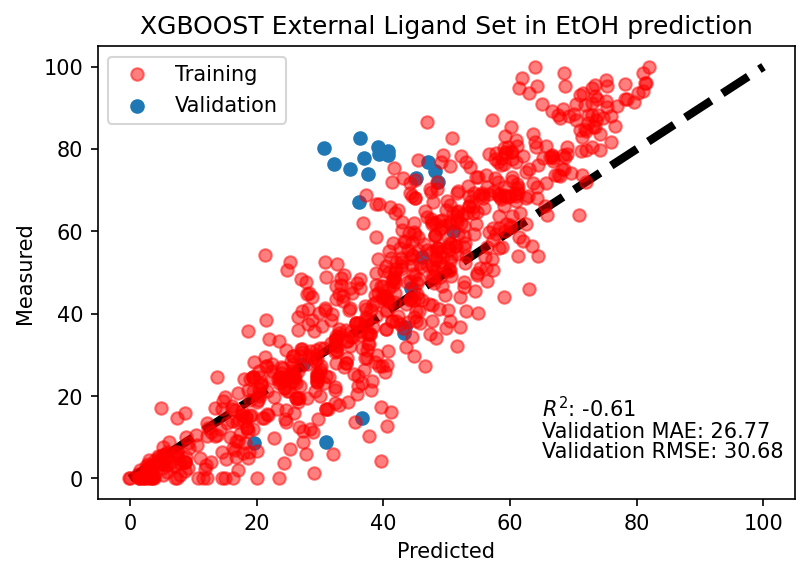

In [14]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.scatter(XGB_Y_Pred,ext_y,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(XGB_cv.predict(X_train), Y_train, "or", alpha=0.5, label="Training")
ax.text(65,15,r'$R^2$: {:0.2f}'.format(r2_score(ext_y,XGB_Y_Pred)))    #make sure actual first predict next!
ax.text(65,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(ext_y,XGB_Y_Pred)))
ax.text(65,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(ext_y,XGB_Y_Pred))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('XGBOOST External Ligand Set in EtOH prediction')
plt.legend()
plt.show()

<AxesSubplot:ylabel='feature'>

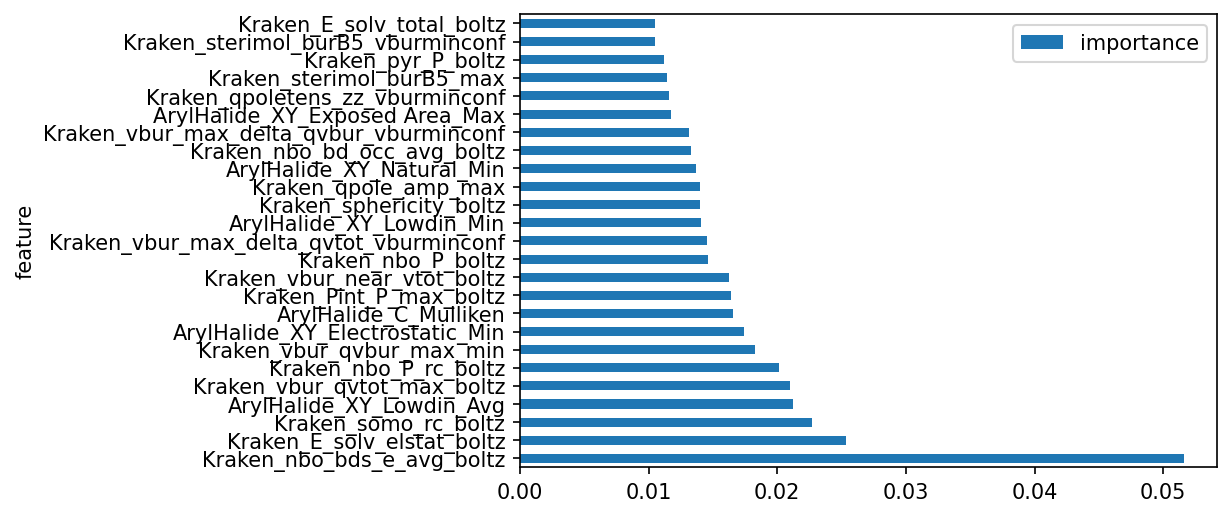

In [15]:
feature_important = XGB_cv.best_estimator_.named_steps["XGB"].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
df = df.head(50)

sorted_idx = XGB_cv.best_estimator_.named_steps["XGB"].feature_importances_.argsort()
df=pd.DataFrame(list(zip(X_train.columns[sorted_idx], 
                      XGB_cv.best_estimator_.named_steps["XGB"].feature_importances_[sorted_idx])))
df2 = df.sort_values(by=[1], ascending=False).head(25)
df2.columns = ['feature', 'importance']
df2.set_index('feature',inplace=True)
df2.plot(kind='barh')

### Shap explainer

In [16]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(XGB_cv.best_estimator_.named_steps["XGB"])
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


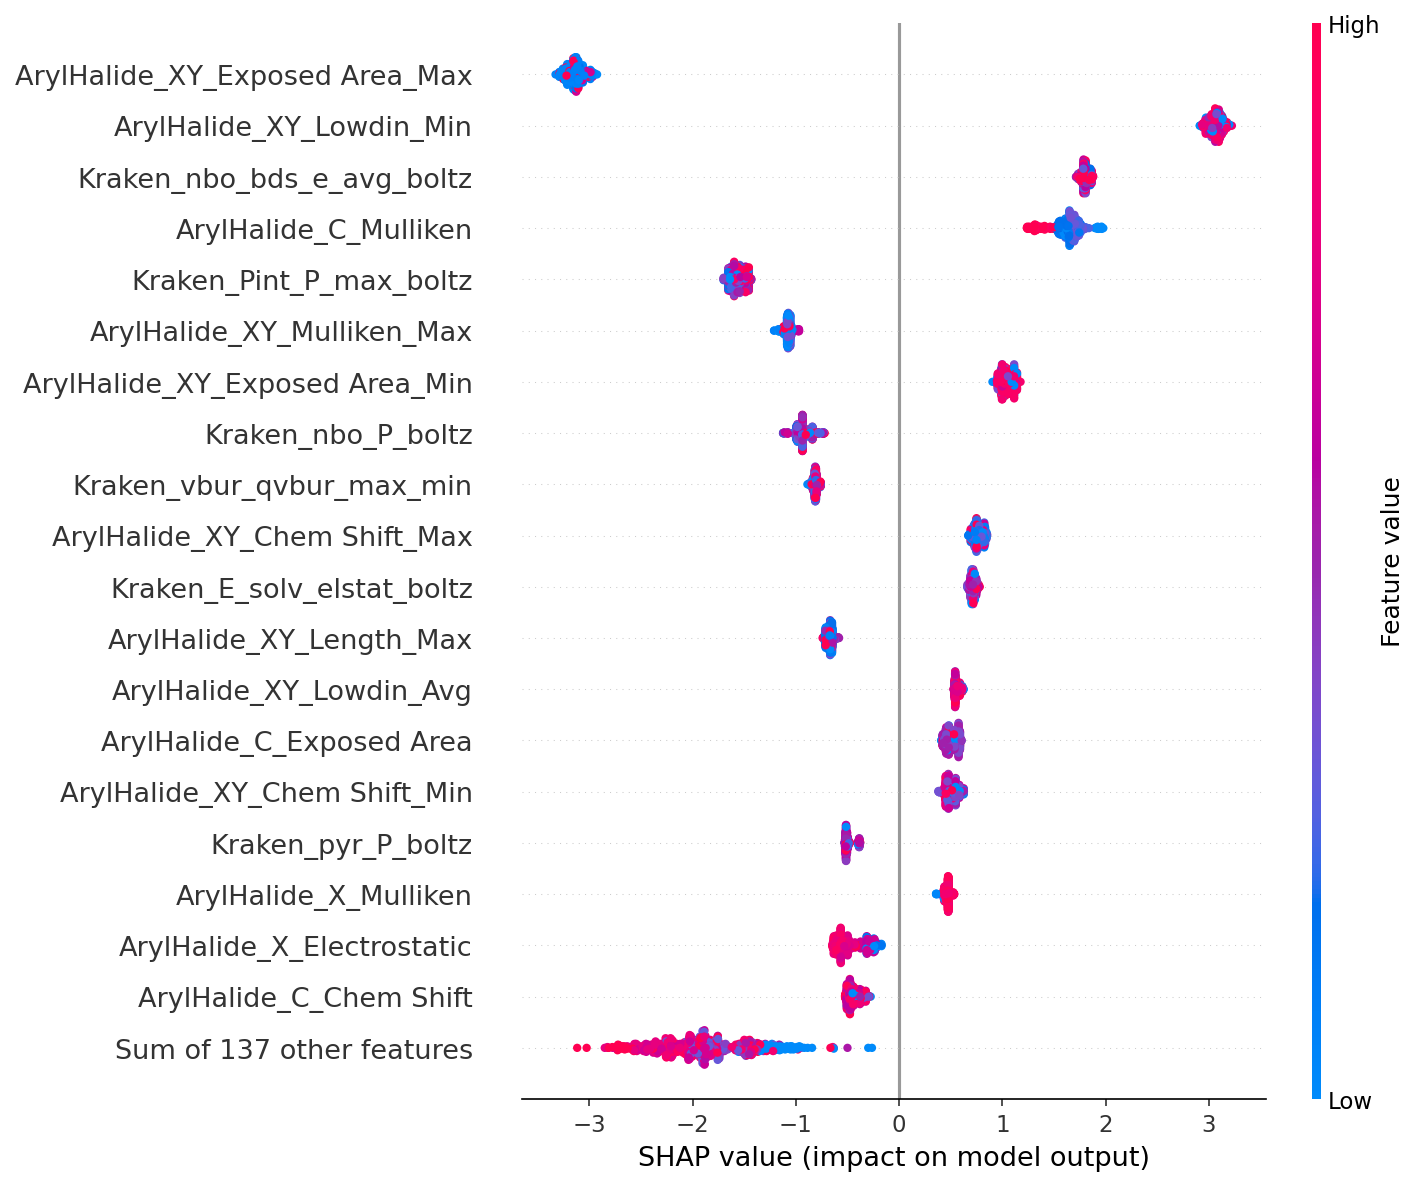

In [17]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=20)

In [18]:
results=ex_dataset[['Electrophile','Ligand','Yield']]
results.reset_index(drop=True, inplace=True)
results['Pred_Yield']=XGB_Y_Pred
results.to_csv("results/XGBOOST_EtOH_Ligand_prediction.csv",index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Save Model

In [19]:
with open('XGBOOST_EtOH_ext_ligand.pkl','wb') as f:
    pickle.dump(XGB_cv.best_estimator_,f)

### Load Model

In [20]:
# load
with open('XGBOOST_EtOH_ext_ligand.pkl', 'rb') as f:
    clf2 = pickle.load(f)

pred=clf2.predict(ext_X)
mse = mean_squared_error(ext_y, pred)
print(math.sqrt(mse))

30.68056373806011
